In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
%matplotlib inline
plt.style.use("fivethirtyeight")

# Exploration

In [4]:
df = pd.read_csv("blackjack.csv")

In [5]:
df.shape

(60000, 20)

In [6]:
df.describe()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_card_one,player_card_two,player_inital,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy
count,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000
mean,4.0,6.543983,14.551550,0.408683,0.559583,18.085933,0.178917,6.544933,6.555733,14.558000,0.572700,0.842933,19.901133,0.297700,0.545967,0.071583,0.38245,0.500000
std,0.0,3.152961,4.086537,0.491595,0.775560,4.379856,0.383286,3.149473,3.152575,4.084991,0.494691,0.895178,3.900822,0.457251,0.497887,0.257799,0.48599,0.500004
min,4.0,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,4.0,4.000000,12.000000,0.000000,0.000000,16.000000,0.000000,4.000000,4.000000,12.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,4.0,7.000000,15.000000,0.000000,0.000000,19.000000,0.000000,7.000000,7.000000,15.000000,1.000000,1.000000,20.000000,0.000000,1.000000,0.000000,0.00000,0.500000
75%,4.0,10.000000,18.000000,1.000000,1.000000,21.000000,0.000000,10.000000,10.000000,18.000000,1.000000,1.000000,22.000000,1.000000,1.000000,0.000000,1.00000,1.000000
max,4.0,10.000000,21.000000,1.000000,5.000000,26.000000,1.000000,10.000000,10.000000,21.000000,1.000000,6.000000,28.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [9]:
df.groupby("strategy")[["player_wins"]].sum()

,player_wins
strategy,
0,10920
1,12027


In [90]:
result_cols = ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins"]

# Hypothesis testing

In [91]:
# Simulate trials of 100 games
def sim_trial(strategy=0):
    sub = df[df.strategy == strategy]
    to_get = np.random.choice(sub.index, 100)
    trials = sub.ix[to_get]
    trials = trials[result_cols]
    return pd.DataFrame(trials.sum()).T

In [92]:
sim_trial()

,dealer_busts,player_busts,player_loses,draw,player_wins
0,13,44,58,8,34


In [93]:
def n_trials(strategy=0, n=5000):
    trials = sim_trial(strategy=strategy)
    for _ in range(n-1):
        trials = pd.concat([trials, sim_trial(strategy=strategy)])
    return trials

In [94]:
ran = n_trials()
rec = n_trials(strategy=1)

In [95]:
# combine with older files
def save_file(trials, filename):
    try:
        old_trials = pd.read_csv(filename+".csv")
        trials = pd.concat([old_trials, trials])
    except:
        pass
    trials.to_csv(filename+".csv", index=False)

In [96]:
save_file(ran, "ran_trials")
save_file(rec, "rec_trials")

In [97]:
ran = pd.read_csv("ran_trials.csv")
rec = pd.read_csv("rec_trials.csv")

In [98]:
print (ran.shape)
print (rec.shape)

(5000, 5)
(5000, 5)


## Number of wins

$H_0$: There is no difference in expected number of wins for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of wins for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

- Instead of simulating trials, we'll draw random samples from the dataset that we've created

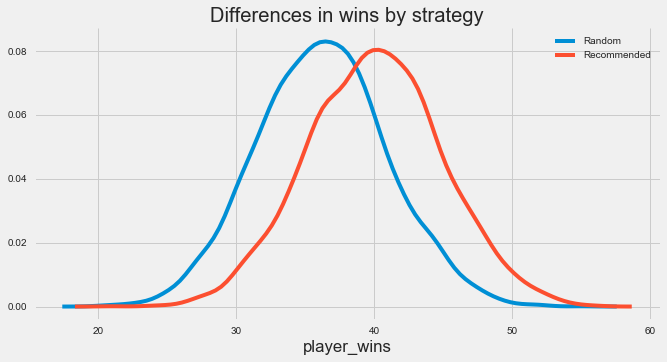

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_wins, 
             hist=False, label="Random");
sns.distplot(rec.player_wins, 
             hist=False, label="Recommended");
ax.set_title("Differences in wins by strategy");
sns.despine();

In [100]:
# Is the difference significant?
stats.ttest_ind(ran.player_wins, rec.player_wins)

Ttest_indResult(statistic=-39.712768763739746, pvalue=0.0)

## Number of losses

$H_0$: There is no difference in expected number of losses for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of losses for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

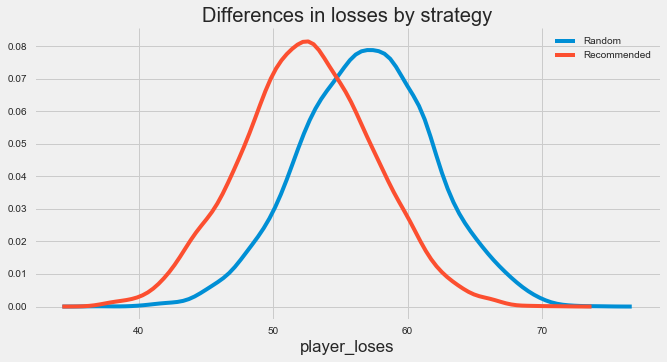

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_loses, 
             hist=False, label="Random");
sns.distplot(rec.player_loses, 
             hist=False, label="Recommended");
ax.set_title("Differences in losses by strategy");
sns.despine();

In [102]:
# Is the difference significant?
stats.ttest_ind(ran.player_loses, rec.player_loses)

Ttest_indResult(statistic=44.650230195301724, pvalue=0.0)

## Number of busts

$H_0$: There is no difference in expected number of busts for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of busts for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

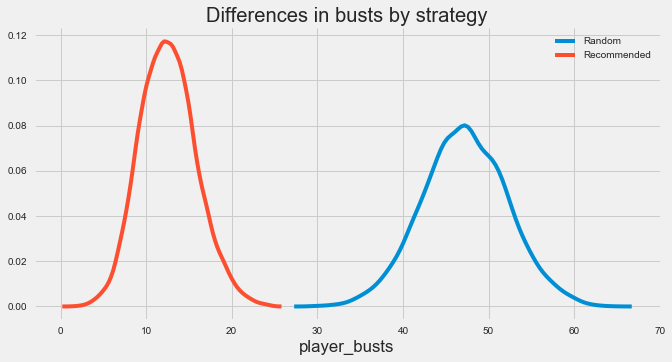

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_busts, 
             hist=False, label="Random");
sns.distplot(rec.player_busts, 
             hist=False, label="Recommended");
ax.set_title("Differences in busts by strategy");
sns.despine();

In [105]:
# Is the difference significant?
stats.ttest_ind(ran.player_busts, rec.player_busts)

Ttest_indResult(statistic=410.2475553872091, pvalue=0.0)

## What about dealer busts?

$H_0$: There is no difference in expected number of busts for the dealer between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of busts for the dealer between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

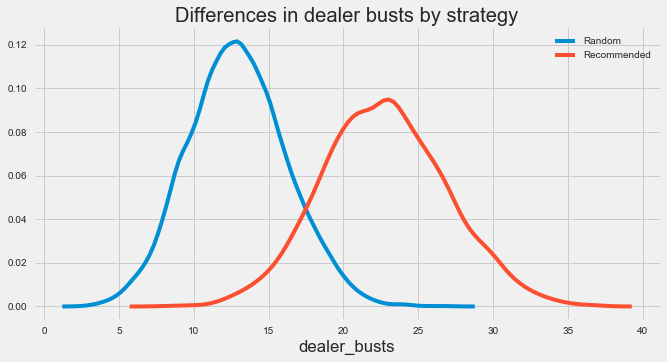

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.dealer_busts, 
             hist=False, label="Random");
sns.distplot(rec.dealer_busts, 
             hist=False, label="Recommended");
ax.set_title("Differences in dealer busts by strategy");
sns.despine();

In [107]:
# Is the difference significant?
stats.ttest_ind(ran.dealer_busts, rec.dealer_busts)

Ttest_indResult(statistic=-130.95294932367025, pvalue=0.0)

# Looking at the dataset

In [108]:
df.head()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_card_one,player_card_two,player_inital,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy,dealer_hand,player_hand
0,4,10,19,0,0,19,0,9,9,18,1,1,24,1,1,0,0,0,"K,9","9,9,6"
1,4,10,20,0,0,20,0,6,6,12,1,2,24,1,1,0,0,0,"Q,10","6,6,3,9"
2,4,4,14,0,0,14,0,5,4,9,1,2,25,1,1,0,0,0,"4,Q","5,4,6,J"
3,4,6,10,0,0,10,0,10,4,14,1,2,22,1,1,0,0,0,"6,4","Q,4,A,7"
4,4,8,12,0,0,12,0,3,4,7,1,2,22,1,1,0,0,0,"8,4","3,4,5,10"


In [40]:
score_cols = ["player_loses", "draw", "player_wins"]

## Analysis by one card

- To determine if we want to split
- Look at the probability of winning based on one card
    - Use first card for simplicity

In [41]:
one_card = df.groupby(["player_card_one", "strategy"])[score_cols].sum()
one_card.reset_index(inplace=True)
one_card["cases"] = one_card[score_cols].apply(sum, axis=1)
one_card.head()

,player_card_one,strategy,player_loses,draw,player_wins,cases
0,1,0,274,70,458,802
1,1,1,261,61,429,751
2,2,0,503,41,242,786
3,2,1,439,34,273,746
4,3,0,487,35,204,726


In [42]:
for i in score_cols:
    one_card["p_"+i] = one_card[i]/one_card["cases"]

In [30]:
one_card.head()

,player_card_one,strategy,player_loses,draw,player_wins,cases,p_player_loses,p_draw,p_player_wins
0,1,0,274,70,458,802,0.341646,0.087282,0.571072
1,1,1,261,61,429,751,0.347537,0.081225,0.571238
2,2,0,503,41,242,786,0.639949,0.052163,0.307888
3,2,1,439,34,273,746,0.588472,0.045576,0.365952
4,3,0,487,35,204,726,0.670799,0.048209,0.280992


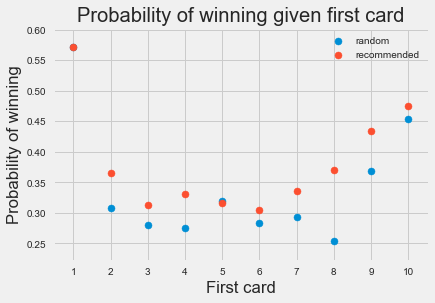

In [31]:
plt.scatter(one_card[one_card["strategy"]==0][["player_card_one"]], 
            one_card[one_card["strategy"]==0][["p_player_wins"]], label="random");
plt.scatter(one_card[one_card["strategy"]==1][["player_card_one"]], 
            one_card[one_card["strategy"]==1][["p_player_wins"]], label="recommended");
plt.legend();
plt.title("Probability of winning given first card");
plt.xlabel("First card");
plt.xticks(np.arange(1,11));
plt.ylabel("Probability of winning");

## Analysis by initial points

In [32]:
df.columns

Index(['num_decks', 'dealer_open', 'dealer_initial', 'dealer_hit',
       'dealer_num_hits', 'dealer_3_card', 'dealer_final', 'dealer_busts',
       'player_card_one', 'player_card_two', 'player_initial', 'player_hit',
       'player_num_hits', 'player_3_card', 'player_final', 'player_busts',
       'player_loses', 'draw', 'player_wins', 'strategy', 'dealer_hand',
       'player_hand'],
      dtype='object')

### By player

In [46]:
player_start = df.groupby(["player_initial", "strategy"])[score_cols].sum()
player_start.reset_index(inplace=True)
player_start["cases"] = player_start[score_cols].apply(sum, axis=1)
for i in score_cols:
    player_start["p_"+i] = player_start[i]/player_start["cases"]
player_start.head()

,player_initial,strategy,player_loses,draw,player_wins,cases,p_player_loses,p_draw,p_player_wins
0,4,0,39,4,14,57,0.684211,0.070175,0.245614
1,4,1,31,1,18,50,0.620000,0.020000,0.360000
2,5,0,82,5,32,119,0.689076,0.042017,0.268908
3,5,1,82,6,37,125,0.656000,0.048000,0.296000
4,6,0,110,8,56,174,0.632184,0.045977,0.321839


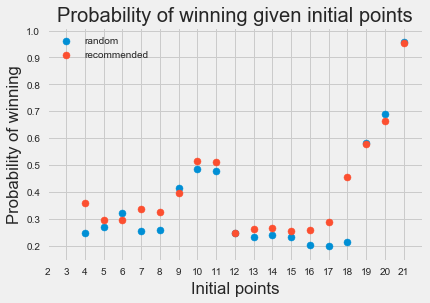

In [47]:
plt.scatter(player_start[player_start["strategy"]==0][["player_initial"]], 
            player_start[player_start["strategy"]==0][["p_player_wins"]], label="random");
plt.scatter(player_start[player_start["strategy"]==1][["player_initial"]], 
            player_start[player_start["strategy"]==1][["p_player_wins"]], label="recommended");
plt.legend();
plt.title("Probability of winning given initial points");
plt.xlabel("Initial points");
plt.xticks(np.arange(2,22));
plt.ylabel("Probability of winning");

### By dealer

In [48]:
dealer_start = df.groupby(["dealer_initial", "strategy"])[score_cols].sum()
dealer_start.reset_index(inplace=True)
dealer_start["cases"] = dealer_start[score_cols].apply(sum, axis=1)
for i in score_cols:
    dealer_start["p_"+i] = dealer_start[i]/dealer_start["cases"]
dealer_start.head()

,dealer_initial,strategy,player_loses,draw,player_wins,cases,p_player_loses,p_draw,p_player_wins
0,4,0,28,1,19,48,0.583333,0.020833,0.395833
1,4,1,30,5,22,57,0.526316,0.087719,0.385965
2,5,0,76,10,48,134,0.567164,0.074627,0.358209
3,5,1,58,13,49,120,0.483333,0.108333,0.408333
4,6,0,89,7,68,164,0.542683,0.042683,0.414634


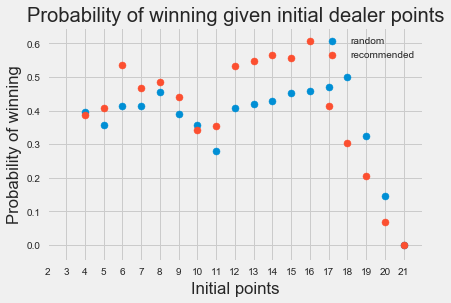

In [49]:
plt.scatter(dealer_start[dealer_start["strategy"]==0][["dealer_initial"]], 
            dealer_start[dealer_start["strategy"]==0][["p_player_wins"]], label="random");
plt.scatter(dealer_start[dealer_start["strategy"]==1][["dealer_initial"]], 
            dealer_start[dealer_start["strategy"]==1][["p_player_wins"]], label="recommended");
plt.legend();
plt.title("Probability of winning given initial dealer points");
plt.xlabel("Initial points");
plt.xticks(np.arange(2,22));
plt.ylabel("Probability of winning");

### By player and dealer

In [54]:
p_and_d = df.groupby(["dealer_initial", "player_initial", "strategy"])[score_cols].sum()
p_and_d.reset_index(inplace=True)
p_and_d["cases"] = p_and_d[score_cols].apply(sum, axis=1)
for i in score_cols:
    p_and_d["p_"+i] = p_and_d[i]/p_and_d["cases"]
p_and_d.head()

,dealer_initial,player_initial,strategy,player_loses,draw,player_wins,cases,p_player_loses,p_draw,p_player_wins
0,4,5,0,2,0,0,2,1.000000,0.00,0.000000
1,4,7,1,2,1,1,4,0.500000,0.25,0.250000
2,4,8,0,0,0,1,1,0.000000,0.00,1.000000
3,4,8,1,2,0,0,2,1.000000,0.00,0.000000
4,4,9,0,2,0,1,3,0.666667,0.00,0.333333


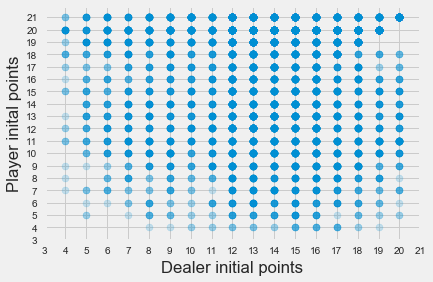

In [55]:
plt.scatter(x="dealer_initial", y="player_initial", data=df[df.player_wins==1], alpha=0.2);
plt.xlabel("Dealer initial points");
plt.ylabel("Player inital points");
plt.xticks(np.arange(3,22));
plt.yticks(np.arange(3,22));

# Given your first 2 cards and the dealer's open card (i.e. the open cards on the table), what's the probability that you end up with X points?

In [122]:
final_points = pd.pivot_table(df, index=["dealer_open", "player_card_one", "player_card_two"], 
                              columns="player_final", values="player_wins", aggfunc=len)
final_points.reset_index(inplace=True)

In [123]:
final_points.head()

player_final,dealer_open,player_card_one,player_card_two,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,5.0,4.0,2.0,NaN,1.0,NaN,1.0,NaN
1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,4.0,1.0,4.0,1.0,1.0,1.0,NaN,2.0
2,1,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,6.0,NaN,1.0,3.0,NaN,NaN,1.0,1.0
3,1,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,2.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN
4,1,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,4.0,NaN,NaN,NaN,1.0,NaN,NaN


In [130]:
pd.melt(final_points, id_vars=["dealer_open", "player_card_one", "player_card_two"], value_vars=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])

,dealer_open,player_card_one,player_card_two,player_final,value
0,1,1,1,4,NaN
1,1,1,2,4,NaN
2,1,1,3,4,NaN
3,1,1,4,4,NaN
4,1,1,5,4,NaN
5,1,1,6,4,NaN
6,1,1,7,4,NaN
7,1,1,8,4,NaN
8,1,1,9,4,NaN
9,1,1,10,4,NaN


In [117]:
final_points["open_cards"] = 0

In [118]:
for i in final_points.index:
    final_points["open_cards"][i] = int("".join(str(i) for i in sorted([final_points.dealer_open[i], 
                                                                        final_points.player_card_one[i], 
                                                                        final_points.player_card_two[i]])))

/Users/joce/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [119]:
final_points.head()

player_final,dealer_open,player_card_one,player_card_two,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,open_cards
0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,4.0,2.0,NaN,1.0,NaN,1.0,NaN,111
1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,1.0,4.0,1.0,1.0,1.0,NaN,2.0,112
2,1,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,6.0,NaN,1.0,3.0,NaN,NaN,1.0,1.0,113
3,1,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,114
4,1,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,4.0,NaN,NaN,NaN,1.0,NaN,NaN,115


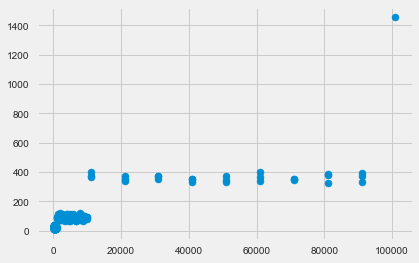

In [81]:
plt.scatter(final_points.open_cards, final_points.player_final);